# COGS 108 - Final Project 

### Analysis of contributions towards job automation

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that PIDs will be scraped from the public submission, but student names will be included.)

* [  ] YES - make available
* [  ] NO - keep private

# Overview

With the United States slated to lose over [1.5 million jobs](https://www.usnews.com/news/economy/articles/2019-06-26/report-robots-will-replace-20-million-manufacturing-jobs-by-2030#:~:text=The%20rise%20of%20robots%20and,jobs%20lost%20in%20China%20alone.) to automation in the next decade alone, the causes of job automation can be a hot topic to many. This project looks at many factors we think will contribute to the probability of a job being automated, including annual and state-level income, the skills required for the job, job field growth over time, and the importance of the job to a state's total workforce. We have seen income does correlate with the likelihood of automation to some extent, low paying jobs will contribute more to state-wide automation.

# Names

- Michael Baluja
- Griffin Mittleman
- Deepkiran Sangha
- Hannah Williams

# Group Members IDs

- A14499660
- A15734955
- A15096006
- A16112910

# Research Question

How is the further integration of job automation into the United States’ workforce related to employment salaries, skills, and employment rates across various job industries in the past 25 years?

## Background and Prior Work

### Background


References (include links):
- 1) [Study: Kiosk Demand on the Rise in Quick Service](qsrmagazine.com/technology/study-kiosk-demand-rise-quick-service)
- 2) [Amazon is expanding its cashierless Go model into a full-blown grocery store](https://www.theverge.com/2020/2/25/21151021/amazon-go-grocery-store-expansion-open-seattle-cashier-less)
- 3) [ASM Tables](https://www.census.gov/programs-surveys/asm/data/tables.html)
- 4) [Why Blue Collar Jobs Are Disappearing](https://www.businessinsider.com/why-blue-collar-jobs-are-dissapearing-2012-1)
- 5) [Unemployment rates and earnings by educational attainment](https://www.bls.gov/emp/chart-unemployment-earnings-education.htm)


### Prior Work

The most similar prior work we have found looks at the Likelihood of Automation with comparisons between Occupation and Salary. The analyses done in this research use the same automation probability dataset that we work with in our analysis (Dataset 1). The second dataset used in this study focuses on a handful of data categories regarding income levels, which we have additionally adopted into our data collection for this project (Dataset 2). In that manner, the aspect of our study considering income and state automation likelihood acts as an extension of the prior work.

References:
- 1) https://data.world/quanticdata/occupation-and-salary-by-state-and-likelihood-of-automation

# Hypotheses


We hypothesize:
- Occupations with higher salaries will have a lower probability of being automated.
- Jobs with high automation probabilities will show a stagnant or decreasing change in employment rates for the eight-year period of time surrounding the point at which the automation likelihood was estimated.
- High perception and manipulation skills correlate more to a high probability of automation.
- High creative and social intelligence scores correlate more with a low probability of automation.

# Dataset(s)

Outline: (Delete before final submission!)
*Fill in your dataset information here*

(Copy this information for each dataset)
- Dataset Name:
- Link to the dataset:
- Number of observations:

1-2 sentences describing each dataset. 

If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

Dataset 1:
- Dataset Name: Occupations by State and Likelihood of Automation
- Link to the dataset: https://data.world/wnedds/occupations-by-state-and-likelihood-of-automation
- Number of observations: 702 (1 per occupation)

This dataset includes job title, OCC code (used to categorize), probability of occupation, and number of employees per state.

Dataset 2:
- Dataset Name: Wage by Occupation
- Link to the dataset: https://data.world/quanticdata/occupation-and-salary-by-state-and-likelihood-of-automation/workspace/file?filename=national_M2016_dl.xlsx
- Number of observations: 1394

This dataset includes job title, OCC code, and various wage metrics per occupation (salary vs hourly, average pay, statistics for these fields, North American Industry Classification System code, employee number data, etc).

Dataset 3:
- Dataset Name: Employment by State
- Link to the dataset: https://www.bea.gov/data/employment/employment-by-state
- Number of observations: 51 (states + DC)

This dataset includes the number of employees per occupation present per state in any given year.

Dataset 4:
- Dataset Name: Employed persons by detailed occupation and age (table 11b)
- Link to the dataset:  https://www.bls.gov/cps/tables.htm
- Number of observations: 567

These datasets (collected for years between 2011 and 2019) show the number of employees per occupation by age group, and gives the total number of employees per occupation.

Dataset 5:
- Name: ONET Job Skills/Abilities/Features
- Link: https://www.onetonline.org/find/descriptor/browse/Skills/
- Number of Observations: 969

Dataset 5 is collecting information from 9 various datasets from the ONET site. These datasets are: Negotiation, social perceptiveness, persuasion, finger dexterity, manual dexterity, cramped work spaces, originality, creativity, and assisting and caring for others. They are all sorted by SOC code and contain 969 observations. 

<br><br>
Datasets 1,2 provide information by occupations will be combined by their OCC code, since it is the most standard metric they share (note: some datasets have different occupation name string formatting, so this is not as easily used). Since we mostly want to consider this data in terms of probability of automation, data from Dataset 2 will only be kept if there is a corresponding OCC code in Dataset 1. Dataset 3 is used to turn the number of employees per occupation per state in Dataset 1 into fractions so we can look at relative numbers of employement as opposed to absolute numbers. 

The 7 datasets from Dataset 4 (corresponding to 2013-2019 data) will be combined in order to calculate the change in employment over the 7 year period. This data will be combined by Dataset 1 by OCC code in order to investigate the relationship between job field growth and likelihood of automation for that job field.


# Setup

In [1]:
# Installs plotly for displaying geospatial graphs
#!pip install --user plotly #Uncomment this out

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import patsy
import statsmodels.api as sm
#import plotly.graph_objects as go
from scipy import stats
from copy import copy
from scipy.stats import normaltest

In [3]:
# Used for building geo-spatial maps
states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 
          'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois','Indiana', 'Iowa', 'Kansas', 
          'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 
          'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 
          'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 
          'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 
          'West Virginia', 'Wisconsin', 'Wyoming']

states_abbv = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 
               'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 
               'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 
               'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 
               'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

# Data Cleaning

**How ‘clean’ is the data?**

Our data are clean in that they were provided by reputable sources who provided the data in a format without any unnecessary variables, null data, etc. For one of the datasets, some wage information was represented by a * or #, with the * meaning not enough data was available for inclusion, and the # meaning wage exceeded $200,000/yr. These observations were dropped from our analyses

**What did you have to do to get the data into a usable format?**

Since some datasets were read in from excel datasheets, it was necessary to clean this data by removing the first few rows (title information), renaming the columns for proper identification, and resetting the index since the first n rows were removed. It was also necessary to remove additional columns that were not related to the dataframe, but were added for structural purposes in the excel datasheet.

Some dataframes required transposing/reshaping in order to more easily work with the data.


**What pre-processing steps were required for your methods?**

For our state analysis, it was necessary to transpose our data in the beginning, since the variables in the original dataset were now to be used as observations in this new dataset. An additional transformation was made to “normalize” the number of employees in each column by dividing them by the total number of workers per state.

We checked the distribution of variables such as probability of automation, wage, and employment percent change.

For the data in Datasets 4, we needed to drop all non-total employee rows and merge the 9 datasets into one set.

For the individual occupation wage analysis, it was necessary to drop most columns. We included occ code, annual mean wage, and occupation. The resulting dataset was merged with Dataset 1 by occ/soc code so we could easily compare the likelihood of automation and the annual mean wage.


In [4]:
# Function tidy-izes the data
def organize(df, year):
    '''
    - Removes the first 7 columns from the dataframe (corresponds to title and additional non-data cells from
    excel formatting)
    - Adds column titles back in
    - Drops null columns
    - Trims dataframe to only include occupation and title
    '''
    df = df[7:]
    df = df.rename(columns={df.columns[0]: 'Occupation', df.columns[1]: 'Total{}'.format(year)})
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df = df[['Occupation', 'Total{}'.format(year)]]
 
    return df

In [5]:
# Creating the pertinent DataFrames
df_prob = pd.read_csv('datasets/raw_state_automation_data.csv', encoding='cp1252')
df_employment = pd.read_excel('datasets/employmentbystate.xls')
df_wages = pd.read_excel('datasets/wagedata.xlsx')
unemployment = pd.read_csv('datasets/USunemployment.csv')
economyData = pd.read_csv('datasets/economy-and-growth-indicators-for-united-states-1.csv')
economyState = pd.read_csv('datasets/SAEMP25N__ALL_AREAS_1998_2018.csv')
income = pd.read_csv('datasets/PARPI_PORT_2008_2017.csv')
df_occ = pd.read_csv('datasets/raw_state_automation_data.csv', encoding='cp1252')


employment2011 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2011.xlsx'), 2011)
employment2012 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2012.xlsx'), 2012)
employment2013 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2013.xlsx'), 2013)
employment2014 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2014.xlsx'), 2014)
employment2015 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2015.xlsx'), 2015)
employment2016 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2016.xlsx'), 2016)
employment2017 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2017.xlsx'), 2017)
employment2018 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2018.xlsx'), 2018)
employment2019 = organize(pd.read_excel('datasets/blsdata/cpsaat11b2019.xlsx'), 2019)

# Merging the different employment datasets in order to analyze percent change
employment = pd.merge(pd.merge(employment2011, employment2012), \
                      pd.merge(pd.merge(employment2013, pd.merge(employment2014, employment2015)), \
                               pd.merge(pd.merge(employment2016, employment2017), \
                                        pd.merge(employment2018, employment2019))))

# Creating copy of main dataframe to avoid issues with individual cleaning and analyses
df_prob_m = copy(df_prob)
df_prob_g = copy(df_prob)
df_prob_h = copy(df_prob)
df_prob_k = copy(df_prob)

## Employment by Occupation

In [6]:
# Structure main dataset
df_prob_m.sort_values(by=['SOC'], inplace=True)

# Standardize Occupation column between datasets
employment['Occupation'] = employment['Occupation'].apply(lambda x: x.title())
df_prob_m['Occupation'] = df_prob_m['Occupation'].apply(lambda x: x.title())

# Create trimmed dataset
df_prob_m_trim = df_prob_m[['SOC', 'Occupation', 'Probability']]

# Include employment info
df_prob_m_trim = pd.merge(df_prob_m_trim, employment)

# Add percent change based on 2012 to 2019 data (Note that data cannot be analyzed for 2011 as there were some
## states in which occupations did not have employees, causing a division by 0 error)
df_prob_m_trim['percent_change'] = (df_prob_m_trim.Total2019 - df_prob_m_trim.Total2012)/df_prob_m_trim.Total2012

## Wage by Occupation

In [7]:
#Remove unnecessary wage data
df_wages = df_wages[['OCC_CODE', 'OCC_TITLE', 'A_MEAN']]
df_wages.rename(columns={'OCC_CODE':'SOC', 'OCC_TITLE':'Occupation'},inplace=True)

# Create combined probability & wages dataset
df_probwages_m = pd.merge(df_prob_m, df_wages, how='left', left_on='SOC', right_on='SOC')

# Drop rows if no mean wage info
# * is used to represent occupation with insufficient data
df_probwages_m = df_probwages_m[df_probwages_m.A_MEAN != '*']

# Remove any null income values
df_probwages_m.dropna(inplace=True,subset=['A_MEAN'])
df_probwages_m = df_probwages_m.reset_index()

# Rest of values should be numeric, so transform
df_probwages_m.A_MEAN = pd.to_numeric(df_probwages_m.A_MEAN)

# Add log mean income 
df_probwages_m['log_A_MEAN'] = df_probwages_m.A_MEAN.apply(np.log)

## Employment & Automation by State 

In [8]:
# Clean employment data by removing excel specific titles & rows, dropping null data
## adding proper column names, dropping unnecessary columns, and typecasting
df_employment = df_employment[5:]
df_employment.dropna(inplace=True)
df_employment = df_employment.rename(columns={df_employment.columns[1]:'State', df_employment.columns[2]:'Employment'})
df_employment.reset_index(inplace=True)
df_employment = df_employment[['State', 'Employment']]
df_employment.Employment = df_employment.Employment.astype(int)

# Reshape data to easily apply later transformation
df_employment = df_employment.transpose()
df_employment.columns = df_employment.iloc[0]
df_employment = df_employment.iloc[1:]

# Transform employment data to reflect employment relative to population
df_prob_m_normed = copy(df_prob_m)
for state in states:
    df_prob_m_normed[state] = df_prob_m_normed[state].apply(lambda x: x/df_employment[state])

# Don't need SOC values, so remove
#df_prob_m.drop(columns=['SOC'],inplace=True)

## Wage by State

In [9]:
income = income[['GeoName', 'LineCode','2008', '2009', '2010', '2011', '2012', '2013', '2014' , '2015', '2016', '2017']]
income = income[income.LineCode == 1.0]
income = income.loc[income.index > 0]

In [10]:
income = income.reset_index()
income = income.drop('index', 1)

In [11]:
N = 2
totalIn = income.groupby(income.index // N).sum()

In [12]:
totalIn['change'] = totalIn['2017'] - totalIn['2008']
totalIn['change'] = totalIn['change'] / totalIn['2008']

In [13]:
# Only want to look at probability, state data so remove other columns
df_occ.drop(columns=['SOC', 'Occupation'], inplace=True)

In [14]:
# Transform employment data to reflect employment relative to population
for state in states:
    df_occ[state] = df_occ[state].apply(lambda x: x/df_employment[state])

In [15]:
state_likelihood2 = []
for state in states:
    likelihood2 = 0
    for index in range(len(df_occ)):
        likelihood2 += df_occ['Probability'][index] * df_occ[state][index]
    state_likelihood2.append(likelihood2)

In [16]:
statesDF = pd.DataFrame(states)
totalIncomeState = totalIn.merge(statesDF, left_index = True, right_index = True)
totalIncomeState = totalIncomeState.rename(columns={0: "State"})

In [17]:
likelihoodAutomation = pd.DataFrame(state_likelihood2)
incomeANDautomation = likelihoodAutomation.merge(totalIncomeState, left_index=True, right_index=True)
incomeANDautomation = incomeANDautomation.rename(columns={0: "Automation"})

## Job Skillset

In [18]:
# Setting up automation data 
automation = pd.read_csv('datasets/raw_state_automation_data.csv', encoding='cp1252')
#removing States data 
automation.drop(automation.columns.difference(['SOC','Occupation', 'Probability']), 1, inplace=True) 
automation['Probability'] = automation['Probability'] * 100

In [19]:
#Loading in all the job skills data
originality = pd.read_csv('datasets/Originality.csv')
negotiation = pd.read_csv('datasets/Negotiation.csv')
social_percept = pd.read_csv('datasets/Social_Perceptiveness.csv')
persuasion = pd.read_csv('datasets/Persuasion.csv')
finger_dext = pd.read_csv('datasets/Finger_Dexterity.csv')
manual_dext = pd.read_csv('datasets/Manual_Dexterity.csv')
cramped_work = pd.read_csv('datasets/Cramped_Work_Space_Awkward_Positions.csv')
fine_arts = pd.read_csv('datasets/Fine_Arts.csv')
df_prob_h = pd.read_csv('datasets/Assisting_and_Caring_for_Others.csv')

In [20]:
#Cleaning and merging 
df_prob_h['Assisting and Caring Importance'] = df_prob_h['Importance']
# Removing doubles "importance" column and level column as it is not used
df_prob_h = df_prob_h.drop(['Importance', 'Level'], axis=1)
df_prob_h['Originality Importance'] = originality['Importance']
df_prob_h['Negotiation Importance'] = negotiation['Importance']
df_prob_h['Social Perception Importance'] = social_percept['Importance']
df_prob_h['Persuasion Importance'] = persuasion['Importance']
df_prob_h['Finger Dexterity Importance'] = finger_dext['Importance']
df_prob_h['Manual Dexterity Importance'] = manual_dext['Importance']
df_prob_h['Cramped Work Context'] = cramped_work['Context']
df_prob_h['Fine Arts Importance'] = fine_arts['Importance']

In [21]:
#Merging the Data Sets
df_prob_h['SOC'] = df_prob_h['Code'].astype(str).replace('\.00', '', regex=True)
df_prob_h = pd.merge(left=df_prob_h, right=automation, left_on='SOC', right_on='SOC')
df_prob_h.drop(['Code', 'Occupation_x'], axis=1, inplace=True)
df_prob_h = df_prob_h.rename(columns = {'Occupation_y':'Occupation'})

In [22]:
#Creating 3 Seperate Categories Based Upon 
df_prob_h['Perception_and_Manipulation'] = df_prob_h[['Finger Dexterity Importance','Manual Dexterity Importance', 
                                       'Cramped Work Context']].mean(axis=1)
df_prob_h['Creative_Intelligence'] = df_prob_h[['Originality Importance','Fine Arts Importance']].mean(axis=1)

df_prob_h['Social_Intelligence'] = df_prob_h[['Social Perception Importance', 'Negotiation Importance', 
                                'Persuasion Importance', 'Assisting and Caring Importance']].mean(axis=1)

# Data Analysis & Results

## Employment by Occupation

### EDA

**Distributions**

Our probability of automation variable is bound between 0-1 with a bimodal distribution. The peaks occur at the two boundaries. While the left mode has a higher peak, the right mode carries more weight.

Our variable representing the percent change in employment between 2012 and 2019 follows a relatively normal unimodal distribution with few mini-peaks that do not change the shape drastically. This distribution is slightly right-skewed.

**Outliers**

While there is a relatively smooth distribution outside of the boundary peaks, there is a non-modal peak in the 0.35-0.40 probability bin.

There is a percent change outlier right around 4 (400% percent change). This corresponds to Transit And Railroad Police, which grew from 1,000 to 5,000 employees.

**Relationship between variables**

There is a very poor (horizontal) linear relation between the probability of automation and change in employment between 2012 and 2019. There is a stronger linear relationship between log annual income and probability of automation.

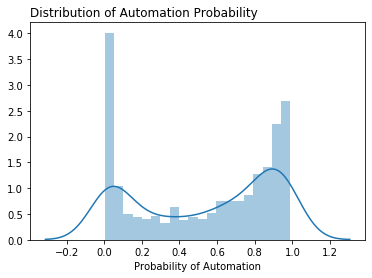

In [23]:
# Distribution of probability of automation
sns.distplot(df_prob_m.Probability, bins=20)
plt.xlabel('Probability of Automation')
plt.title('Distribution of Automation Probability', loc='left')
plt.show()

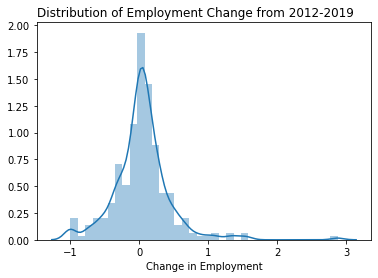

In [24]:
# Distribution of percent change in employment
sns.distplot(df_prob_m_trim.percent_change)
plt.xlabel('Change in Employment')
plt.title('Distribution of Employment Change from 2012-2019', loc='left')
plt.show()

In [25]:
# Investigate outlier
df_prob_m_trim[df_prob_m_trim.percent_change >= 3.5]

,SOC,Occupation,Probability,Total2011,Total2012,Total2013,Total2014,Total2015,Total2016,Total2017,Total2018,Total2019,percent_change


In [26]:
# Determine normality of percent_change
k2, p = stats.normaltest(df_prob_m_trim.percent_change)
print(p)

1.2612948679979974e-24


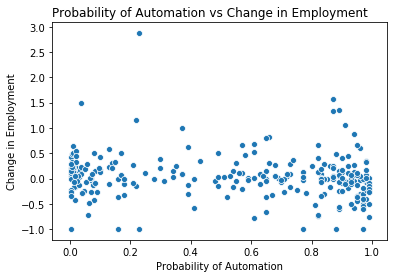

In [27]:
# Plot the percent change vs Probability of employment
sns.scatterplot(df_prob_m_trim.Probability, df_prob_m_trim.percent_change)
plt.xlabel('Probability of Automation')
plt.ylabel('Change in Employment')
plt.title('Probability of Automation vs Change in Employment', loc='left')
plt.show()

### Analysis

**What approaches did you use? Why?**

We analyze the relationship between percent change in employment and probability of automation using an OLS Linear Regression model. This method of analysis was chosen because there is a relatively linear relationship between the two variables.

In [28]:
# OLS Regression for Probability and percent change
# NOTE: Data does not meet requirements necessary for testing linearity, but want to take a look 

outcome, predictors = patsy.dmatrices('Probability ~ percent_change', df_prob_m_trim)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            Probability   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                 -0.150
Method:                 Least Squares   F-statistic:                    0.8500
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.761
Time:                        20:07:27   Log-Likelihood:                 140.34
No. Observations:                 274   AIC:                             197.3
Df Residuals:                      35   BIC:                             1061.
Df Model:                         238                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

**What were the results?**

The results from our analysis of the relationship between percent change in employment and the probability of automation shows poor results. Due to the bimodal distribution of the probability of automation, our data was not properly distributed for this type of regression. Further attempts to normalize the data did not prove to be successful, nor did further regression attempts.

**What were your interpretation of these findings?**

Although the findings from the relation between employment percent change and automation did not prove to be conclusive of anything, we initially interpreted these results to show that the likelihood (probability) of automation is a complex factor with many contributing factors, and as such, we could not analyze it solely by looking at one possible contributor. This led to a breadth of comparisons being done in order to better understand the different contributing factors to likelihood of automation.

## Income Analysis

### Wage by State

### EDA

**Distributions**
The variable "income" consists of a unimodal distribution.

**Outliers**
There was one outlier in the analysis of automation likelihood vs. percent change in income: District of Columbia, Automation: 0.299355, Income Percent Change: 0.364582.

**Relationship Between Variables**
There is a negative relationship between the likelihood of automation in a state and the percent change in income in a state

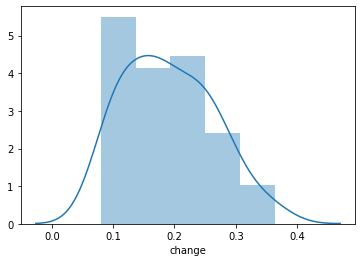

In [29]:
sns.distplot(totalIn.change)

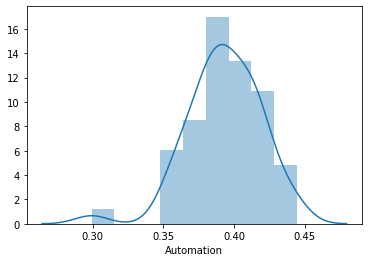

In [30]:
sns.distplot(incomeANDautomation.Automation)

### Analysis: Part 1

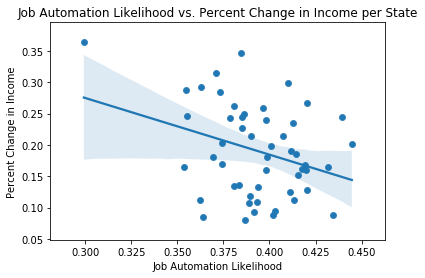

In [31]:
sns.scatterplot(incomeANDautomation.Automation, incomeANDautomation.change)
ax = sns.regplot(x="Automation", y="change", data=incomeANDautomation)
ax.set(title='Job Automation Likelihood vs. Percent Change in Income per State', xlabel='Job Automation Likelihood', ylabel='Percent Change in Income')
plt.show()

**What approaches did you use? Why?**

We analyze the relationship between percent change in income and probability of automation using a Linear Regression model. This was done because there was a clear downwards shape in the data.

In [32]:
outcome2, predictors2 = patsy.dmatrices('Automation ~ change', incomeANDautomation)
model2 = sm.OLS(outcome2, predictors2)
results2 = model2.fit()

print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:             Automation   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     5.671
Date:                Wed, 10 Jun 2020   Prob (F-statistic):             0.0212
Time:                        20:07:29   Log-Likelihood:                 117.09
No. Observations:                  51   AIC:                            -230.2
Df Residuals:                      49   BIC:                            -226.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4151      0.010     42.311      0.0

**What were the results?**

With an alpha value of 0.01, an R value of -0.085 indicates that there is some significance in the correlation between automation likelihood in a state and its percent change in income levels.

**What were your interpretation of these findings?**

Since the correlation value is negative, we can assume that there is a correlation between an increase in automation level and the subsequent decrease in income change. This means that there is a correlation in where as automation levels income, that income levels decrease. 

### Analysis: Part 2

In [33]:
automation1of3 = incomeANDautomation.loc[incomeANDautomation.Automation <= 0.35]
automation2of3 = incomeANDautomation.loc[(incomeANDautomation.Automation > 0.35) & (incomeANDautomation.Automation <= 0.4)]
automation3of3 = incomeANDautomation.loc[incomeANDautomation.Automation > 0.4]

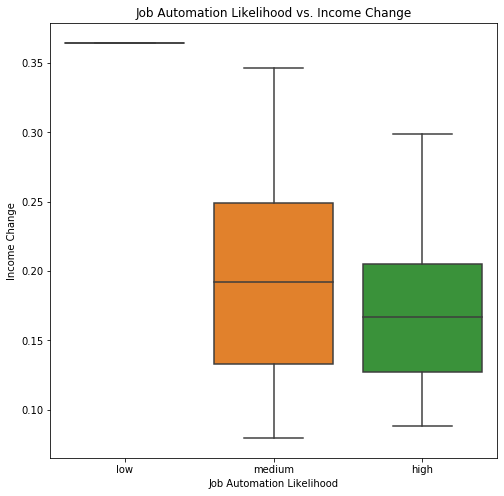

In [38]:
plt.figure(figsize=(8,8))
automation1of3 = automation1of3.assign(Location='low')
automation2of3 = automation2of3.assign(Location='medium')
automation3of3 = automation3of3.assign(Location='high')
cdf = pd.concat([automation1of3, automation2of3, automation3of3]) 
ax = sns.boxplot(x="Location", y="change", data=cdf)
ax.set(title='Job Automation Likelihood vs. Income Change',xlabel='Job Automation Likelihood', ylabel='Income Change')

plt.show()

**What approaches did you use? Why?**

We split the data of Job Automation Likelihood evenly three ways between low probability (p <= 0.35), medium probability (0.35 < p <= 0.4), and high probability (p > 0.4). This was done to better group together the values of automation for easier analysis. It was done so that we have a better understanding of which areas of job automation will have a consequental greater result in income change. 

We then analyze the relationship between percent change in income and probability of automation in low, medium, and high using a Linear Regression model. This was done because we took reference from the original plot and noticed that there was a downward shape in the data in the medium section, but slightly upward in the high section. We wanted to explore whether there is a different relationship between the medium likelihood and high likelihoods of job automation. In our "low" section, we had one data point, which was our outlier, so this form of analysis also gave us the chance to analyze everything beyond the outlier. 

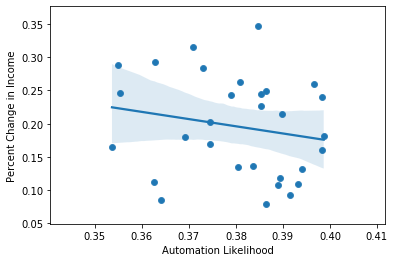

In [41]:
sns.scatterplot(automation2of3.Automation, automation2of3.change)
ax1 = sns.regplot(x="Automation", y="change", data=automation2of3)
ax1.set(xlabel='Automation Likelihood', ylabel='Percent Change in Income')
plt.show()

In [35]:
outcome3, predictors3 = patsy.dmatrices('Automation ~ change', automation2of3)
model3 = sm.OLS(outcome3, predictors3)
results3 = model3.fit()

print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:             Automation   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.112
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.301
Time:                        20:07:29   Log-Likelihood:                 87.546
No. Observations:                  30   AIC:                            -171.1
Df Residuals:                      28   BIC:                            -168.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3871      0.007     55.211      0.0

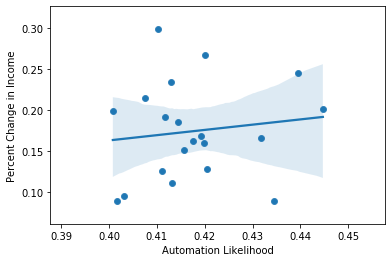

In [42]:
sns.scatterplot(automation3of3.Automation, automation3of3.change)
ax3 = sns.regplot(x="Automation", y="change", data=automation3of3)
ax3.set(xlabel='Automation Likelihood', ylabel='Percent Change in Income')
plt.show()

In [37]:
outcome4, predictors4 = patsy.dmatrices('Automation ~ change', automation3of3)
model4 = sm.OLS(outcome4, predictors4)
results4 = model4.fit()

print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:             Automation   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.038
Method:                 Least Squares   F-statistic:                    0.3098
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.585
Time:                        20:07:30   Log-Likelihood:                 60.719
No. Observations:                  20   AIC:                            -117.4
Df Residuals:                      18   BIC:                            -115.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4129      0.009     47.477      0.0

**What were the results?**

Medium:
With an alpha value of 0.01, an R value of -0.038 indicates that there is significance in the correlation between medium automation likelihood in a state and its percent change in income levels. 

High:
With an alpha value of 0.01, an R value of 0.017 indicates that there is significance in the correlation between large automation likelihood in a state and its percent change in income levels.

**What were your interpretation of these findings?**

Medium:
Since the correlation value is negative, we can assume that there is a correlation between an increase in automation level within the medium range and the subsequent decrease in income change. This means that there is a correlation in where as automation at a medium level increase, that income change levels decrease. 

High:
Something interesting happens here -- the correlation is positive, as opposed to negative. This assumes that there is a correlation between an increase in automation level in the high automation range and also an increase in the levels of income change. While we may not be able to specifically pinpoint why this happens, we can conclude that the impact caused by medium and high levels of job automation are not the same. 

In [39]:
state_incomeChange = []
for state in states:
    incomeChange = 0
    for index in range(len(totalIncomeState)):
        incomeChange = totalIncomeState['change'][index] 
        state_incomeChange.append(incomeChange)

In [40]:
fig = go.Figure(data=go.Choropleth(
    locations=states_abbv,
    z = state_incomeChange,
    locationmode = 'USA-states',
    colorscale = 'Purples',
    colorbar_title =  "Income Change",
))

fig.update_layout(
    title_text = 'Income Percent Change 2008 to 2017',
    geo_scope='usa',
)

fig.show()

NameError: name 'go' is not defined

## Wage by Occupation

### EDA

**Distributions**

Our annual mean wage variable takes a right-skewed normal distribution. We remove the skew by applying a natural log function to this data.

**Outliers**

There is at least one outlier in annual mean income around $225,000

In [ ]:
# Distribution of annual mean income
sns.distplot(df_probwages_m.A_MEAN)
plt.xlabel('Mean Annual Income')
plt.title('Distribution of Mean Annual Income', loc='left')
plt.show()

In [ ]:
# Investigate mean annual income outlier
df_probwages_m[df_probwages_m.A_MEAN > 225000]

We see that these two extremely high paying outliers are both oral health occupations with a low probability of automation.

In [ ]:
# Distribution of log annual mean income
sns.distplot(np.log(df_probwages_m.A_MEAN))
plt.xlabel('Log(Mean Annual Income)')
plt.title('Distribution of log Mean Annual Income', loc='left')
plt.yticks(np.arange(0.0,1.2,0.2))
plt.show()

In [ ]:
# Test normality of log wage
stat_wage_mean_log, p_wage_mean_log = normaltest(df_probwages_m.log_A_MEAN)
print('log mean wage is normally distributed') if p_wage_mean_log < 0.01 else print('log mean wage is NOT normally distributed')

Since the data for log mean wage are normally distributed, we can consider a linear regression model to analyze the relation between income and probability.

### Analysis

**What approaches did you use? Why?**

We analyze the relationship between log annual income and probability of automation by using an OLS Linear Regression model because there is a clear linear relationship between these two variables.

In [ ]:
# Complete regression for relationship between probabilty of automation and log mean annual income
outcome, predictors = patsy.dmatrices('Probability ~ log_A_MEAN', df_probwages_m)
model = sm.OLS(outcome, predictors)
results = model.fit()

print(results.summary())

In [ ]:
# Look at ditribution of probability and log annual income
sns.scatterplot(df_probwages_m.Probability, df_probwages_m.log_A_MEAN)
plt.xlabel('Probability of Automation')
plt.ylabel('Mean Annual Income')
plt.title('Probability of Automation vs Mean Annual Income', loc='left')
plt.show()

**What were the results?**

The results from our analysis of the relationship between log annual income and the probability of automation provide a $P|t|$ value of 0.000, with an Adjusted $R^2$ value of 0.330.

**What were your interpretation of these findings?**

We interpret the findings between log annual income and probability of income to support our initial hypothesis that lower paying jobs are more likely to suffer from job automation. Although our $R^2$ value is low from the OLS Regression we performed, our 0.000 p value shows that this data is at least conclusive. We believe that further analysis with additional variables can improve our adjusted $R^2$ value. However, it is important to be cautious with these findings, since our probability of automation data are not normally distributed.

## Employment & Automation by State

### Analysis

**What approaches did you use? Why?**

For analysing which jobs are most likely to most contribute to automation, we look at the total number of employees per occupation in each state, and take that as a percent of the total number of working employees in that state. That percentage is then multiplied by the occupation's respective probability of automation, and each state is summed across each occupation. This gives the relative weighted likelihood of automation across each state. We further look at which occupation most contributes to this factor, and organize this data geospatially. We chose to analyze this data in this way because it gave a relative score that allows us to compare each state’s overall probability of automation, instead of having our data skewed by looking at absolute employment values. This method also gives insight on which jobs need further attention in our analyses.

In [ ]:
# Build composite likelihood of unemployment per state
state_likelihood = []
df_state_data = pd.DataFrame()
for state in states:
    likelihood = 0.0
    max_likelihood = 0.0
    for index in range(len(df_prob_m)):
        new_likelihood = df_prob_m['Probability'][index] * df_prob_m_normed[state][index]
        likelihood += new_likelihood
        if  new_likelihood > max_likelihood:
            max_likelihood = new_likelihood
            df_state_data[state] = (df_prob_m.Occupation[index], df_prob_m[state][index], df_prob_m.SOC[index])
         
    state_likelihood.append(likelihood)
    #print('state: {}\n\t {}'.format(state, likelihood))

In [ ]:
# Transform state data dataframe for easier manipulation
df_state_data = df_state_data.transpose()
df_state_data.rename(columns={0:'Occupation', 1:'Number', 2:'SOC'},inplace=True)

In [ ]:
# Change datatype for number of employees
df_state_data.Number = df_state_data.Number.astype(str)

In [ ]:
# Look at the occupations that most contribute to a state's weighted likelihood of automation, along with the
## occupation's respective wage and number of states in which it is the top contributor
for occupation in df_state_data.Occupation.unique():
    SOC = df_state_data[df_state_data.Occupation == occupation].SOC.unique()[0]
    wage = int(df_wages[df_wages.SOC == SOC].A_MEAN.values[0])
    n_states = len(df_state_data[df_state_data.Occupation == occupation])
    print('Occupation: {}\n   Wage: {}\n   Num States: {}'.format(occupation, wage, n_states))

From this we can see that an the most overwhelming amount of jobs that will be lost due to automation will occur to retail salespeople. (This analysis looks at the amount of people affected multiplied by the probability of automation)

In [ ]:
# Add text column for hover-info on map
df_state_data['text'] = df_state_data.index + '<br>' + \
'Most affected occupation: ' + df_state_data.Occupation + '<br>' + \
'Num employees of occupation in state: ' + df_state_data.Number

# Plot the weighted likelihood of automation by state
fig = go.Figure(data=go.Choropleth(
    locations=states_abbv, # Spatial coordinates
    z = state_likelihood, # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'blues',
    colorbar_title =  "Automation Probability",
    autocolorscale=False,
    text = df_state_data.text
))

fig.update_layout(
    title_text = 'Likelihood of Job Automation by State',
    geo_scope='usa', # limite map scope to USA
)

fig.show()

**What were the results?**

The results from our analysis between likelihood of automation by state show that there are only five different jobs across all 50 states + DC (51 total “areas”) that are the area’s highest contributors towards job automation. These occupations include cashiers, retail workers, administrative assistants, food prep & service workers, and office clerical workers. For 40 out of the 51 areas we analyze, the highest contributing occupation are retail workers. This occupation has an average US wage of around $27,000, which is less than half of the average income for 2016 in which this data were collected, and falls below the first quartile for US workers. We also see that the lowest aggregate probability of automation is in DC, at 29.93\% total risk of automation. The highest contributor in DC is secretaries.

**What were your interpretation of these findings?**

We interpret the findings of our state-automation data to support our hypothesis that lower-paying jobs will be more susceptible to job automation than higher paying jobs would. Since this statistic is based on the number of employees per occupation, it is necessary to make the distinction that this metric looks at the probability of automation for the highest number of jobs. A job with 100 employees and a .99 probability of automation would have the same metric as a job with 1000 employees and a .099 probability of automation. 

It is also interesting to consider secretaries in DC. The secretary position is the highest paying occupation from the five highest-contributor occupations. We interpret this under the assumption that a secretary is a relatively common job in DC (with each of the many political positions, among others, requiring at least one secretary). This means that secretaries make up a significant amount of the jobs held in DC, but current technological advancements like digital assistants and phone screenings may soon be capable of automating this position.

## Job Skillsets 

### EDA

**Distributions**

**Outliers**

**Relationships Between Variables**

In [ ]:
#Distribution of Perception and Manipulation Importance among jobs
sns.distplot(df_prob_h.Perception_and_Manipulation, bins=20)
plt.xlabel('Skill Importance')
plt.title('Importance of Perception and Manipulation Skills', loc='left')
plt.show()

In [ ]:
#Distribution of Creative Intelligence Importance among jobs
sns.distplot(df_prob_h.Creative_Intelligence, bins=20)
plt.xlabel('Skill Importance')
plt.title('Importance of Creative Intelligence Skills', loc='left')
plt.show()

In [ ]:
#Distribution of Social Intelligence Importance among jobs
sns.distplot(df_prob_h.Social_Intelligence, bins=20)
plt.xlabel('Skill Importance')
plt.title('Importance of Creative Intelligence Skills', loc='left')
plt.show()

### Analysis

**What approaches did you use? Why?**

In [ ]:
#Regression of Perception and Manipulation 
outcome, predictors = patsy.dmatrices('Probability ~ Perception_and_Manipulation', df_prob_h)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

In [ ]:
#Regression of Creative Intelligence 
outcome, predictors = patsy.dmatrices('Probability ~ Creative_Intelligence', df_prob_h)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

In [ ]:
#Regression of Social Intelligence 
outcome, predictors = patsy.dmatrices('Probability ~ Social_Intelligence', df_prob_h)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

In [ ]:
#Perception and Manipulation Box Plot

merged_df1low = df_prob_h.loc[df_prob_h['Probability'] <= 0.33].assign(Location="Low")
merged_df1medium = df_prob_h.loc[(df_prob_h['Probability'] > 0.33) & (df_prob_h['Probability'] <= 0.66)].assign(Location="Medium")
merged_df1high = df_prob_h.loc[df_prob_h['Probability'] > 0.66].assign(Location="High")

allValues = [merged_df1low, merged_df1medium, merged_df1high]
allMerged = pd.concat(allValues)

plt.figure(figsize=(8,8))
cdf = pd.concat([merged_df1low, merged_df1medium, merged_df1high]) 
ax = sns.boxplot(x="Location", y="Perception_and_Manipulation", data=cdf)
ax.set(title='Job Automation Likelihood vs. Perception and Manipulation',xlabel='Job Automation Likelihood', 
       ylabel='Perception and Manipulation Importance')

plt.show()
merged_df1high.shape

In [ ]:
#Creative Intelligence Box Plot

merged_df2low = df_prob_h.loc[df_prob_h['Probability'] <= 0.33].assign(Location="Low")
merged_df2medium = df_prob_h.loc[(df_prob_h['Probability'] > 0.33) & 
                                 (df_prob_h['Probability'] <= 0.66)].assign(Location="Medium")
merged_df2high = df_prob_h.loc[df_prob_h['Probability'] > 0.66].assign(Location="High")

allValues = [merged_df2low, merged_df2medium, merged_df2high]
allMerged = pd.concat(allValues)

plt.figure(figsize=(8,8))
cdf = pd.concat([merged_df2low, merged_df2medium, merged_df2high]) 
ax = sns.boxplot(x="Location", y='Creative_Intelligence', data=cdf)
ax.set(title='Job Automation Likelihood vs. Creative Intelligence Importance',xlabel='Job Automation Likelihood', 
       ylabel='Creative Intelligence Importance')

plt.show()
merged_df2high.shape

In [ ]:
#Social Intelligence Box Plot

merged_df3low = df_prob_h.loc[df_prob_h['Probability'] <= 0.33].assign(Location="Low")
merged_df3medium = df_prob_h.loc[(df_prob_h['Probability'] > 0.33) & 
                                 (df_prob_h['Probability'] <= 0.66)].assign(Location="Medium")
merged_df3high = df_prob_h.loc[df_prob_h['Probability'] > 0.66].assign(Location="High")

allValues = [merged_df3low, merged_df3medium, merged_df3high]
allMerged = pd.concat(allValues)

plt.figure(figsize=(8,8))
cdf = pd.concat([merged_df3low, merged_df3medium, merged_df3high]) 
ax = sns.boxplot(x="Location", y="Social_Intelligence", data=cdf)
ax.set(title='Job Automation Likelihood vs. Social Intelligence Importance',xlabel='Job Automation Likelihood', 
       ylabel='Social Intelligence Importance')

plt.show()
merged_df3high.shape

**What were the results?**

**What were your interpretations of these findings?**

# Ethics & Privacy

All of our datasets have been provided by publicly available sources such as data.world, The Bureau of Labor Statistics, or other US Government agencies. Since these data are being provided to the public, we anticipate no restrictions in using it for the purpose of this project. Additionally, no restrictions have been posted for the datasets we are accessing. Much of the data we are using is provided by state or federal governments, which is required by law to provide strong protection for the data that are available to the public. For the data sources that are not guaranteed to do this, we will provide privacy by anonymizing any potentially personal identifiable information. However, we do not anticipate this being an issue, as all the data collected are aggregates that don’t include any potentially personal identifiable information. Occupations with less than 1,000 employees in a certain state were removed from our data.

One of our dataset sources, data.world, consists of contributors of various backgrounds and experience levels. This increases the potential for bias, since there is no way of confirming whether the presentation of the data is biased towards fulfilling the contributor’s needs. The user has the option of viewing the contributor’s Kaggle profile and their LinkedIn profiles, but the amount of information that is provided to the user is controlled by the contributor themselves. If we utilize the provided information to confirm the legitimacy of the contributor’s data, we can decrease the chance of potential bias. For our other data source, data.gov, there is a smaller potential of bias given the fact that it is a government source. While we cannot assume that government sources are entirely free of bias, we can assume that it is more of a fair source than non-government sources. Government sources are supposed to be free of affiliation to political parties, which is why we can assume that the data presented has relatively low levels of bias.

A potential ethical concern we have considered is data misinformation/misinterpretation. If an individual comes across our analysis without the understanding that this data relies partly on probability instead of concrete metrics, and that this analysis was not conducted by professional Data Scientists, it might lead to the unnecessary spread of fear that one might lose their job to automation, or further contribute to data misinterpretation.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*

Michael:
- Setup/cleaning/eda/analysis/viz:
    - Employment by Automation
    - Wage by Occupation
    - Employment & Automation by State
- Datasets 1-4
- Ethics & Privacy 
- Prior Work & Hypothesis
- Overview

Kiran:
- Setup/cleaning/eda/analysis/viz:
    - Gross Average Unemployment vs. Income United States
    - Wage by State Income Change
    - Analysis of Automation by State vs. Income Change per State
        - Used Michael's code for automation probability generation 
- Datasets 5-8
- Ethics & Privacy 
- Code for boxplots used throughout project

Hannah:
- Datasets for job skills (9 in total)
    - Collected and Data cleaning
    - EDA
        - Created categories for job skills
    - Job skillset analysis and visualization
        - Used Kiran's box plot code
    - Data analysis w/ Griffin
    
Griffin: